# Observable Trends:
1) The strongest correlation is between latitude and temperature, as expected

2) The data from cloudiness from openweather appear to be often rounded to the nearest 5 or 10%

3) There is loose correlation between humidity and latitude, with higher humidity tending to be near the equator

In [360]:
import matplotlib.pyplot as plt
from citipy import citipy
import numpy as np
import pandas as pd
import requests
from configapikey import gkey
import json
import random
import seaborn as sbn

# Generate 1,600 random latitudes and longitudes in attempt to disperse around globe.  1,600 is >> 500 because of duplicate nearby cities from citipy and failed api calls to openweather.

In [361]:

LatList=random.sample(range(0, 1600), 1600)
LatList=pd.DataFrame(LatList)
for i in LatList:
    float(i)
    LatList[0]=LatList[0]*180/1600-90
LatList.rename(columns={0:'Lat'}, inplace=True)
    

LonList=random.sample(range(0, 1600), 1600)
LonList=pd.DataFrame(LonList)
for i in LonList:
    float(i)
    LonList[0]=LonList[0]*360/1600-180
LonList.rename(columns={0:'Lon'}, inplace=True)

#LatList=LatList/180
LatLon = pd.concat([LatList, LonList], axis=1)
#LatLon["City"]=""
LatLon.head()

,Lat,Lon
0,69.4125,-2.925
1,-5.9625,-156.825
2,-65.9250,58.725
3,-4.5000,78.300
4,51.3000,164.925


# For each random lat/lon pair, find nearest city using citipy

In [362]:
City=pd.DataFrame(index=range(0,1600),columns=['City'])

for x in range(0,1600):
    City["City"][x]= citipy.nearest_city(LatLon['Lat'][x], LatLon['Lon'][x]).city_name
LatLon = pd.concat([LatLon, City], axis=1)
LatLon.head()


,Lat,Lon,City
0,69.4125,-2.925,klaksvik
1,-5.9625,-156.825,faanui
2,-65.9250,58.725,taolanaro
3,-4.5000,78.300,hithadhoo
4,51.3000,164.925,nikolskoye


In [363]:
#  Eliminate duplicate cities

LatLon.set_index("City")
UniqueCities = LatLon.drop_duplicates(subset='City')
UniqueCities=UniqueCities.reset_index(drop=True)
UniqueCities.head()

,Lat,Lon,City
0,69.4125,-2.925,klaksvik
1,-5.9625,-156.825,faanui
2,-65.9250,58.725,taolanaro
3,-4.5000,78.300,hithadhoo
4,51.3000,164.925,nikolskoye


In [364]:
weather_json

{'base': 'stations',
 'clouds': {'all': 0},
 'cod': 200,
 'coord': {'lat': 11.14, 'lon': 123.72},
 'dt': 1521526883,
 'id': 1685422,
 'main': {'grnd_level': 1022.64,
  'humidity': 100,
  'pressure': 1022.64,
  'sea_level': 1022.68,
  'temp': 82.82,
  'temp_max': 82.82,
  'temp_min': 82.82},
 'name': 'Sulangan',
 'sys': {'country': 'PH',
  'message': 0.0028,
  'sunrise': 1521496166,
  'sunset': 1521539755},
 'weather': [{'description': 'clear sky',
   'icon': '01d',
   'id': 800,
   'main': 'Clear'}],
 'wind': {'deg': 34.5016, 'speed': 7.43}}

In [365]:
UniqueCities.head()


,Lat,Lon,City
0,69.4125,-2.925,klaksvik
1,-5.9625,-156.825,faanui
2,-65.9250,58.725,taolanaro
3,-4.5000,78.300,hithadhoo
4,51.3000,164.925,nikolskoye


# Pull Data from OpenWeather, 1 City at a Time

In [366]:
# Save config information
url = "http://api.openweathermap.org/data/2.5/weather?"




# Replace nearby Latitude with actual Latitude and get weather data
UniqueCities["LatReal"]=""
UniqueCities["Temperature"]=""
UniqueCities["Humidity"]=""
UniqueCities["Cloudiness"]=""
UniqueCities["Wind_Speed"]=""

for x in range(0,len(UniqueCities)):
    
    ThisCity=UniqueCities['City'][x]
    query_url = url + "appid=" + gkey + "&q=" + ThisCity + "&units=imperial"
    
    weather_response = requests.get(query_url)
    weather_json = weather_response.json()

   #  Bypass "city not found"    
    if weather_response.status_code==404:
        UniqueCities.loc[x,('LatReal')] = "NA"
    else: 
        UniqueCities.loc[x,('LatReal')] = weather_json['coord']['lat']
        UniqueCities.loc[x,('Temperature')] = weather_json['main']['temp']
        UniqueCities.loc[x,('Humidity')] = weather_json['main']['humidity']
        UniqueCities.loc[x,('Cloudiness')] = weather_json['clouds']['all']
        UniqueCities.loc[x,('Wind_Speed')] = weather_json['wind']['speed']
UniqueCities.head()








,Lat,Lon,City,LatReal,Temperature,Humidity,Cloudiness,Wind_Speed
0,69.4125,-2.925,klaksvik,62.23,39.2,98,36,16.11
1,-5.9625,-156.825,faanui,-16.48,80.21,100,44,17.6
2,-65.9250,58.725,taolanaro,NA,,,,
3,-4.5000,78.300,hithadhoo,-0.6,85.25,99,0,13.24
4,51.3000,164.925,nikolskoye,59.7,26.6,92,90,8.95


In [367]:
# Eliminate "bad" data
UniqueCities['Humidity'].replace('', np.nan, inplace=True)
UniqueCities.dropna(subset=['Humidity'], inplace=True)
print(len(UniqueCities))

# Confirm > 500 Cities

UniqueCities.head()

584


,Lat,Lon,City,LatReal,Temperature,Humidity,Cloudiness,Wind_Speed
0,69.4125,-2.925,klaksvik,62.23,39.2,98.0,36,16.11
1,-5.9625,-156.825,faanui,-16.48,80.21,100.0,44,17.6
3,-4.5000,78.300,hithadhoo,-0.6,85.25,99.0,0,13.24
4,51.3000,164.925,nikolskoye,59.7,26.6,92.0,90,8.95
5,86.4000,174.825,pevek,69.7,-16.1,48.0,12,7.2


# Plot Temp vs. Latitude

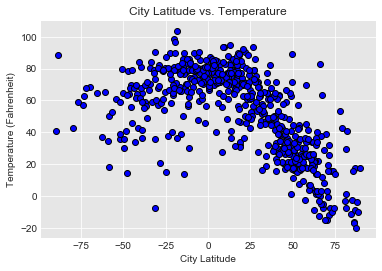

In [378]:
plt.title("City Latitude vs. Temperature")
plt.xlabel("City Latitude")
plt.ylabel("Temperature (Fahrenheit)")
sbn.set_style()
plt.scatter(UniqueCities['Lat'], UniqueCities['Temperature'], marker="o",facecolors="blue", edgecolors="black",)
plt.show()
plt.savefig('temperature.png')


# Plot Humidity vs. Latitude

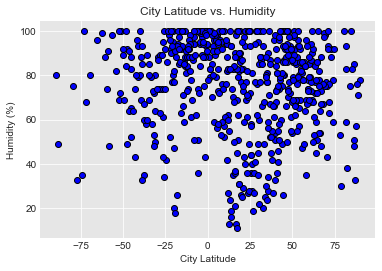

In [377]:
plt.title("City Latitude vs. Humidity")
plt.xlabel("City Latitude")
plt.ylabel("Humidity (%)")
sbn.set_style()
plt.scatter(UniqueCities['Lat'], UniqueCities['Humidity'], marker="o",facecolors="blue", edgecolors="black",)
plt.show()
plt.savefig('humidity.png')

# Plot Cloudiness vs. Latitude

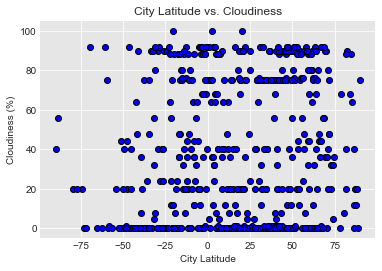

In [376]:
plt.title("City Latitude vs. Cloudiness")
plt.xlabel("City Latitude")
plt.ylabel("Cloudiness (%)")
sbn.set_style()
plt.scatter(UniqueCities['Lat'], UniqueCities['Cloudiness'], marker="o",facecolors="blue", edgecolors="black",)
plt.show()
plt.savefig('cloudiness.png')

# Plot Wind Speed vs. Latitude

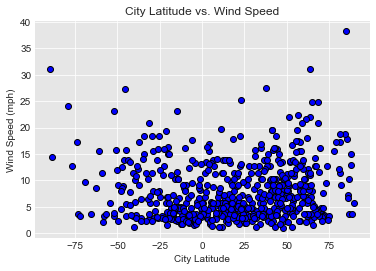

In [375]:
plt.title("City Latitude vs. Wind Speed")
plt.xlabel("City Latitude")
plt.ylabel("Wind Speed (mph)")
sbn.set_style()
plt.scatter(UniqueCities['Lat'], UniqueCities['Wind_Speed'], marker="o",facecolors="blue", edgecolors="black",)
plt.show()
plt.savefig('windspeed.png')

In [372]:
UniqueCities.to_csv('CitiesData.csv')